ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

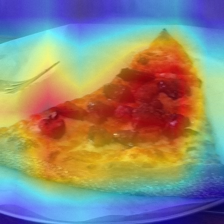

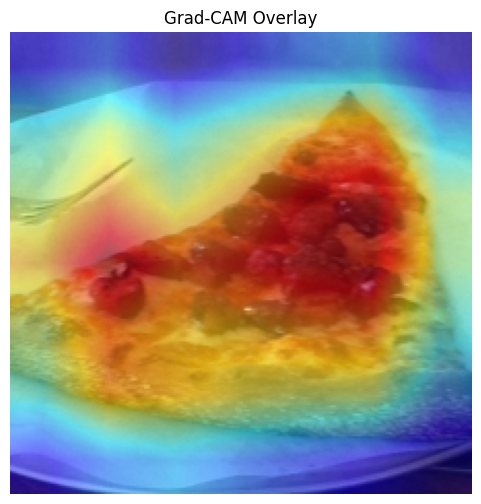

In [10]:
import cv2
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as functional
from torchvision import models, transforms

import warnings
warnings.filterwarnings('ignore')

# Colab-specific import for showing images with OpenCV
from google.colab.patches import cv2_imshow

# ----------------------
# Load pretrained model
# ----------------------
model = models.resnet18(weights=True)
# For newer torchvision versions, you can also use:
# from torchvision.models import ResNet18_Weights
# model = models.resnet18(weights=ResNet18_Weights.DEFAULT)

print(model, "\n\n")
model.eval()

# Choose the target layer (last conv block)
target_layer = model.layer4[1].conv2  # Final conv layer in ResNet18

# ----------------------
# Load and preprocess image
# ----------------------
img_path = '/content/648055.jpg'
img = Image.open(img_path).convert('RGB')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # Optional but recommended for ImageNet models:
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                      std=[0.229, 0.224, 0.225]),
])
input_tensor = transform(img).unsqueeze(0)  # shape: (1, 3, 224, 224)

# ----------------------
# Hooks to capture activations and gradients
# ----------------------
activations = []
gradients = []

def forward_hook(module, input, output):
    activations.append(output)

def backward_hook(module, grad_in, grad_out):
    # grad_out is a tuple; we want the gradient wrt the module's output
    gradients.append(grad_out[0])

# Register hooks
forward_handle = target_layer.register_forward_hook(forward_hook)
backward_handle = target_layer.register_full_backward_hook(backward_hook)

# ----------------------
# Forward pass
# ----------------------
logits = model(input_tensor)
print("----")
print("Logits shape:", logits.shape)   # e.g. (1, 1000)

pred_class = logits.argmax(dim=1)      # predicted class index
print("Predicted class index:", pred_class.item())
print("Predicted logit:", logits[0, pred_class].item())

# ----------------------
# Backward pass (Grad-CAM uses gradient of the predicted class)
# ----------------------
model.zero_grad()
logits[0, pred_class].backward()

# ----------------------
# Get activations and gradients from hooks
# ----------------------
# activations[0]: (1, C, H, W)
# gradients[0]:   (1, C, H, W)
act = activations[0].detach()
grad = gradients[0].detach()

# Remove batch dimension but keep channels
act = act.squeeze(0)   # (C, H, W)
grad = grad.squeeze(0) # (C, H, W)

print("Activation shape:", act.shape)
print("Gradient shape:", grad.shape)

# ----------------------
# Compute Grad-CAM
# ----------------------
# Global average pooling over spatial dimensions to get weights
weights = grad.mean(dim=(1, 2))   # shape: (C,)
print("Weights shape:", weights.shape)

# Vectorized Grad-CAM: sum_c (w_c * A_c)
cam = (weights.view(-1, 1, 1) * act).sum(dim=0)  # shape: (H, W)

# Apply ReLU
cam = functional.relu(cam)

# Normalize CAM to [0, 1]
cam = cam - cam.min()
cam = cam / (cam.max() + 1e-8)

# Convert to NumPy
cam = cam.detach().cpu().numpy()   # shape: (H, W), values in [0, 1]

# ----------------------
# Resize and overlay on image
# ----------------------
# Resize CAM to 224x224
heatmap = cv2.resize(cam, (224, 224))     # float
heatmap = np.uint8(255 * heatmap)         # [0, 255]
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # BGR

# Original image as NumPy (RGB -> then convert to BGR for OpenCV blend)
img_np = np.array(img.resize((224, 224)))          # RGB
img_bgr = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)  # BGR

# Blend heatmap with original image
overlay = cv2.addWeighted(img_bgr, 0.5, heatmap, 0.5, 0)

# ----------------------
# Show result in Colab
# ----------------------
cv2_imshow(overlay)  # overlay is BGR, cv2_imshow handles it

# ----------------------
# (Optional) also show with Matplotlib (expects RGB)
# ----------------------
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Grad-CAM Overlay")
plt.show()

# ----------------------
# Remove hooks (good practice if you reuse the model)
# ----------------------
forward_handle.remove()
backward_handle.remove()
